# Data Collection and Preprocessing

This notebook combines and preprocesses housing sales data from Brooklyn for the years 2012 to 2023. The goal is to clean and prepare the data for analysis and modeling. Steps include data cleaning, feature engineering, and initial visualizations.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
housing_df = pd.read_csv('compiled_housing_sales.csv')
housing_df['neighborhood'] = housing_df['neighborhood'].str.strip().str.upper()

In [3]:
#filter to only houses 
housing_df = housing_df[(housing_df['property_type'] == 'mixed house ') | (housing_df['property_type'] == 'house')]

housing_df.reset_index(drop=True, inplace=True)

In [4]:
#remove outliers 
neighborhood_percentiles = housing_df.groupby('neighborhood')['sale_price'].quantile([0.25, 0.90]).unstack()

def filter_below_25th_percentile(row, percentiles):
    neighborhood = row['neighborhood']
    sale_price = row['sale_price']
    lower_bound = percentiles.loc[neighborhood, .25]
    upper_bound = percentiles.loc[neighborhood, .90]
    return lower_bound < sale_price < upper_bound
    
housing_df_filtered = housing_df[housing_df.apply(filter_below_25th_percentile, axis=1, percentiles=neighborhood_percentiles)]
housing_df_filtered.reset_index(drop=True, inplace=True)

In [5]:
top_20_neighborhoods = housing_df_filtered.groupby('neighborhood').size().sort_values(ascending=False).head(20).index
top_neighborhood_df = housing_df_filtered[housing_df_filtered['neighborhood'].isin(top_20_neighborhoods)]
top_neighborhood_df.reset_index(drop=True, inplace=True)

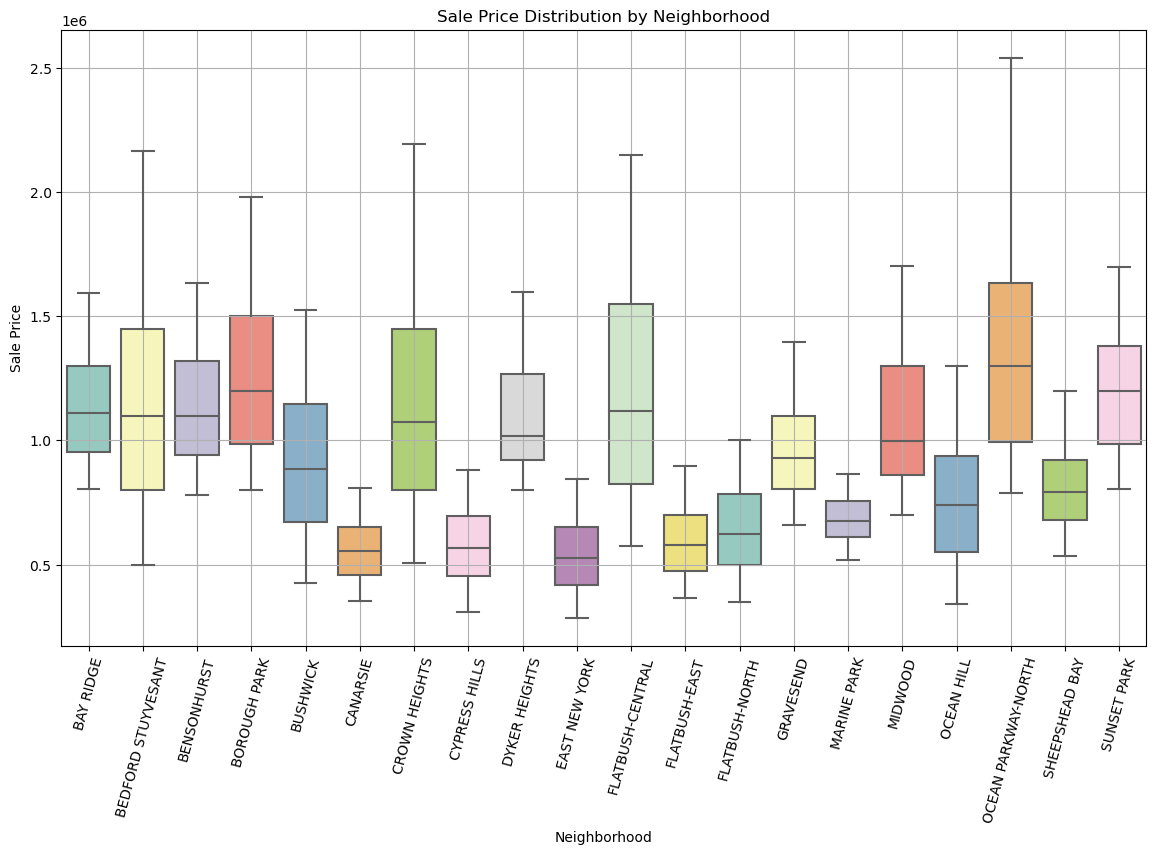

In [6]:
#Boxplot

plt.figure(figsize=(14,8))
sns.boxplot(x='neighborhood', y='sale_price', data=top_neighborhood_df, palette='Set3')
plt.xticks(rotation=75)
plt.title('Sale Price Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Sale Price')
plt.grid(True)
plt.show()

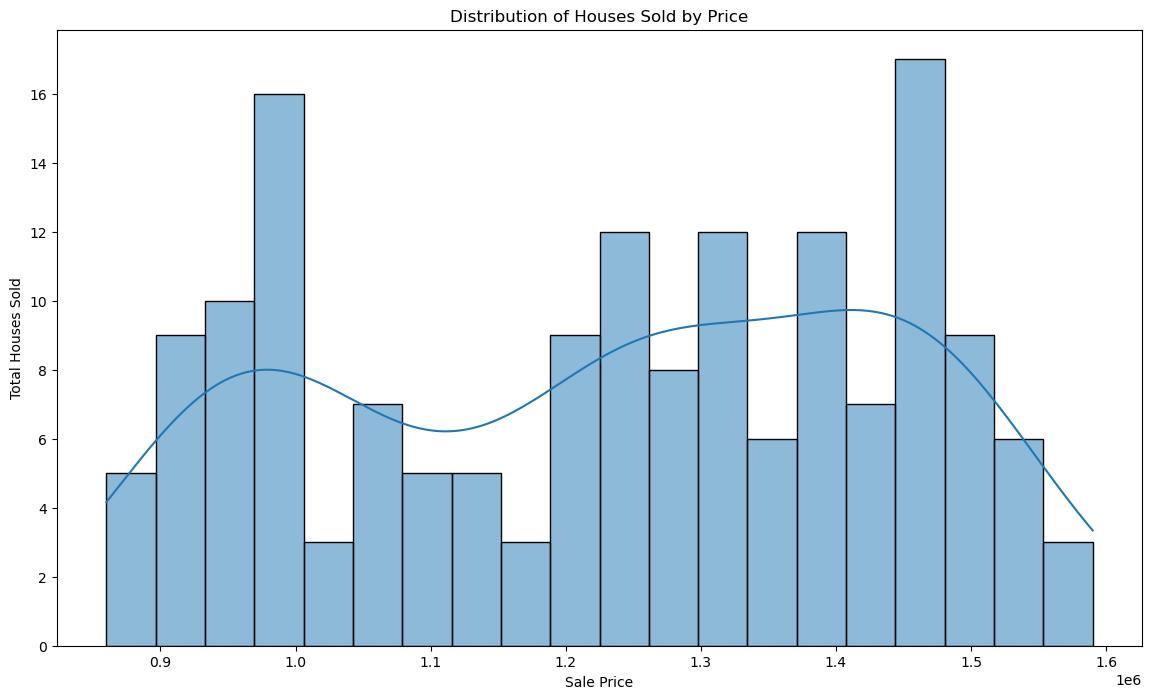

In [7]:
neighborhood_df = housing_df_filtered[(housing_df_filtered['neighborhood'] == 'BAY RIDGE') & (housing_df_filtered['year'] == 2023)]

plt.figure(figsize=(14,8))
sns.histplot(data=neighborhood_df, x='sale_price', bins=20, kde=True)
plt.xlabel('Sale Price')
plt.ylabel('Total Houses Sold')
plt.title('Distribution of Houses Sold by Price')
plt.show()

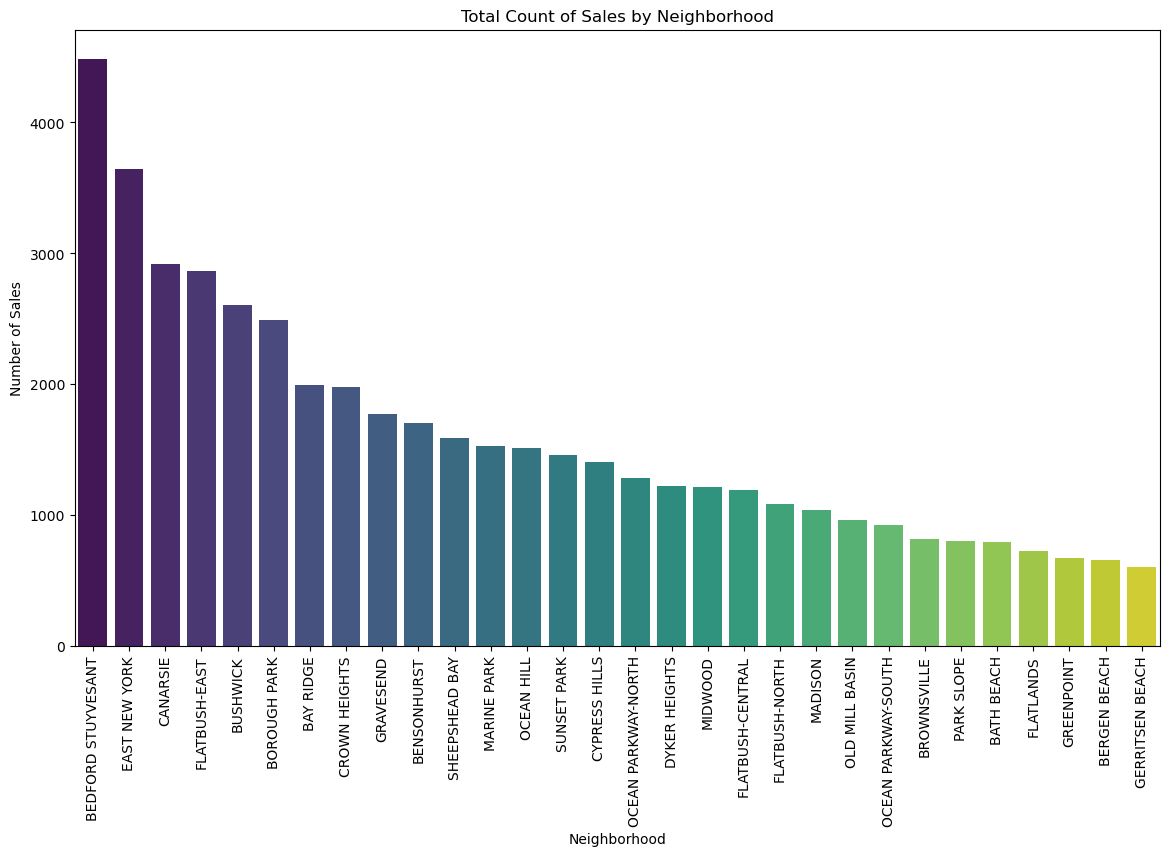

In [8]:
neighborhood_vals = housing_df_filtered['neighborhood'].value_counts().reset_index().head(30)

neighborhood_vals.columns = ['neighborhood', 'num_sales']

plt.figure(figsize=(14,8))
sns.barplot(x='neighborhood', y='num_sales', data=neighborhood_vals, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Number of Sales')
plt.title('Total Count of Sales by Neighborhood')
plt.show()

Text(0.5, 1.0, 'Scatter Plot - Land Sq Feet vs Sale Price')

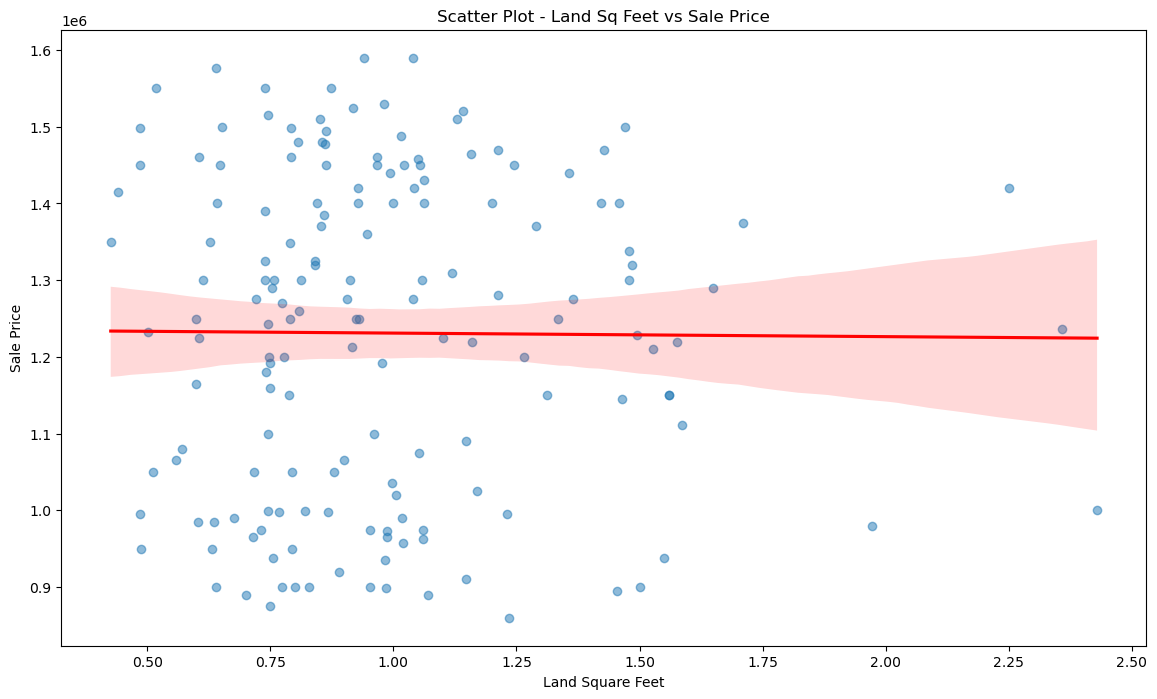

In [9]:
plt.figure(figsize=(14,8))

sns.regplot(x='land_density', y='sale_price', data=neighborhood_df, scatter_kws={'alpha':.5}, line_kws={'color':'red'})
plt.xlabel('Land Square Feet')
plt.ylabel('Sale Price')
plt.title('Scatter Plot - Land Sq Feet vs Sale Price')

<Figure size 1400x800 with 0 Axes>

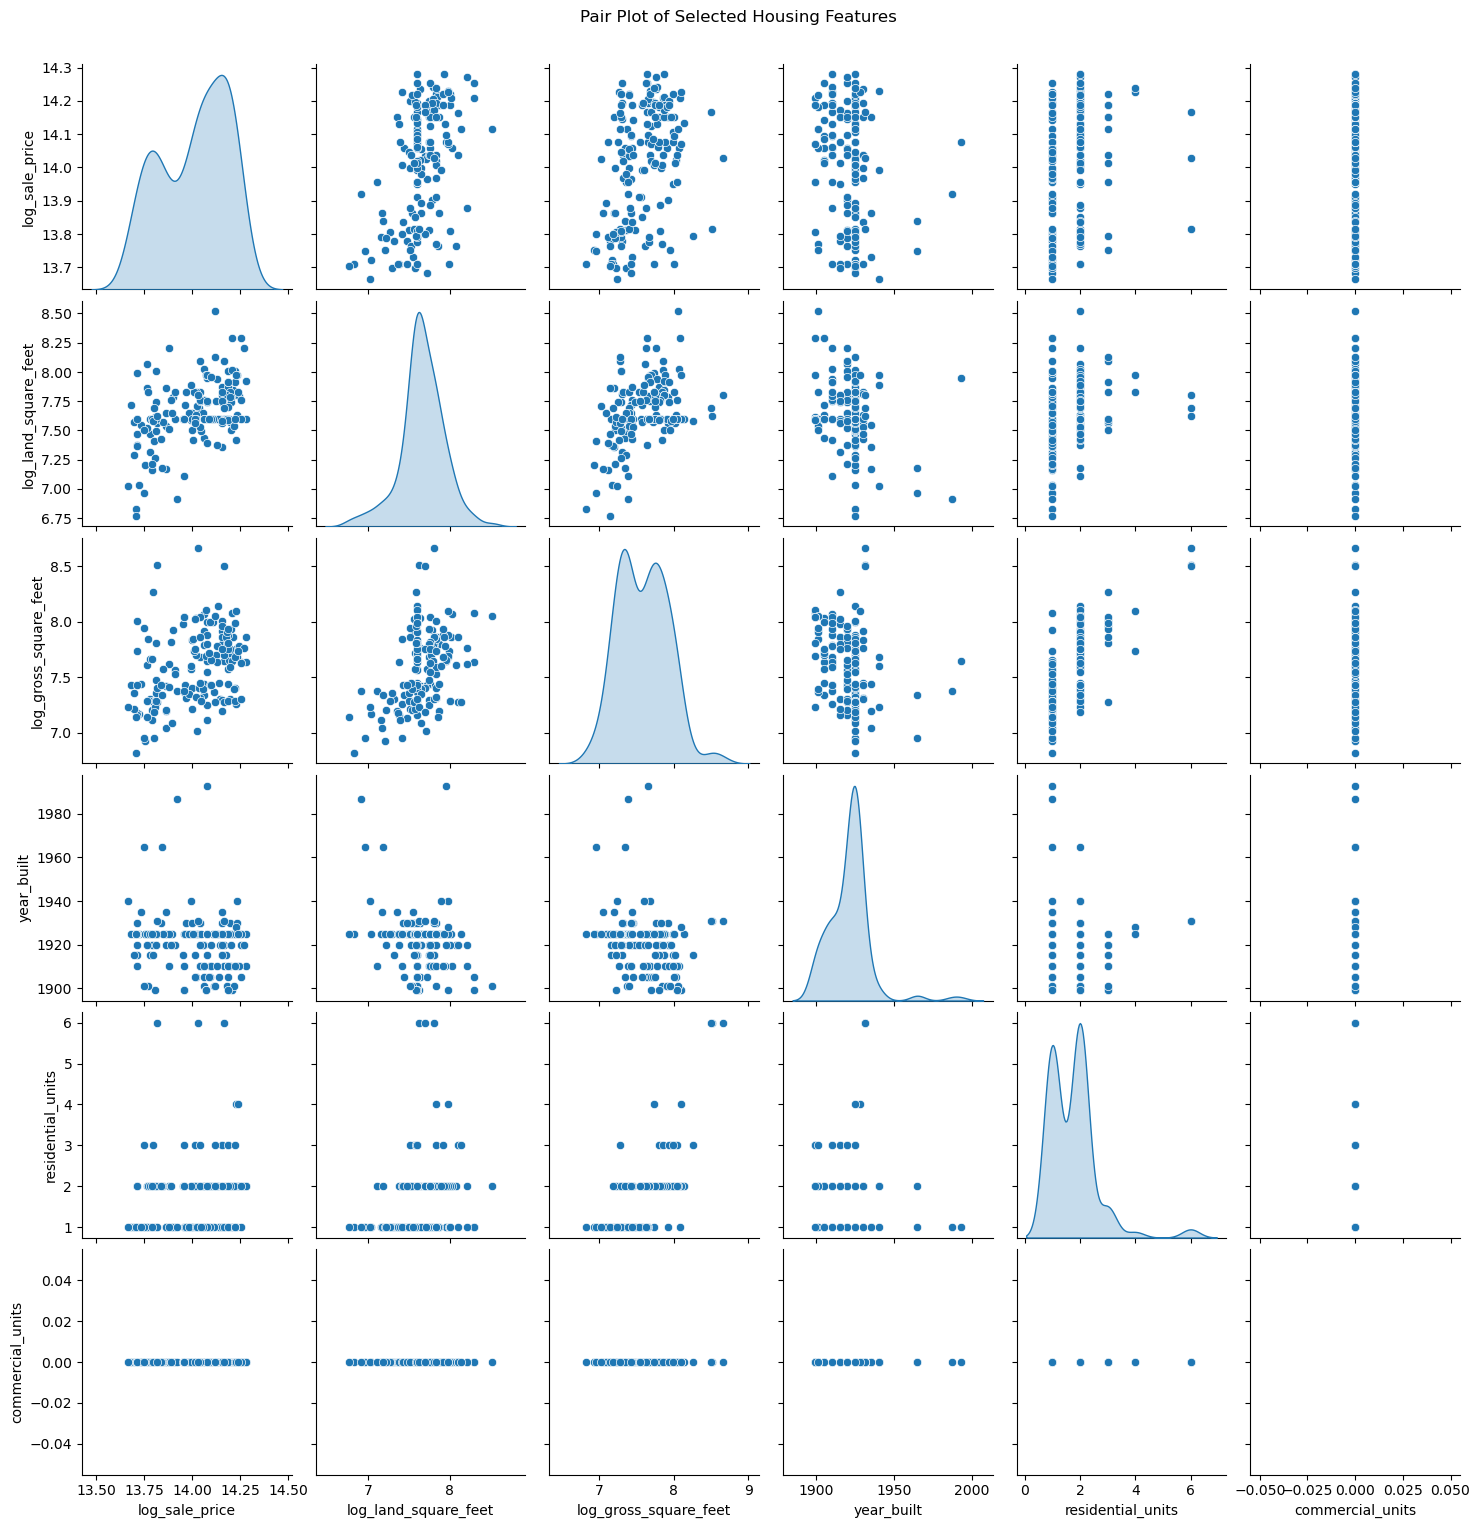

In [10]:
plt.figure(figsize=(14,8))

pairplot_df = neighborhood_df[['log_sale_price', 'log_land_square_feet', 'log_gross_square_feet', 'year_built', 'residential_units', 'commercial_units']]

sns.pairplot(pairplot_df, diag_kind='kde')
plt.suptitle('Pair Plot of Selected Housing Features', y=1.02)
plt.show()


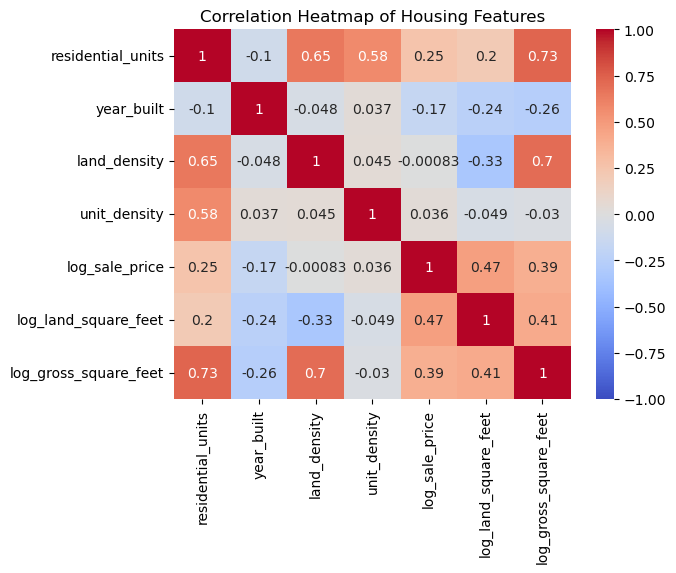

In [11]:
#heatmap

#pick numerical metrics 

heatmap_df = neighborhood_df[['residential_units', 'year_built', 'land_density', 'unit_density', 'log_sale_price', 'log_land_square_feet', 'log_gross_square_feet']]

corr_matrix = heatmap_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Housing Features')
plt.show()

In [12]:
#one hot encoding 
housing_df_encoded = pd.get_dummies(housing_df_filtered, columns=['neighborhood'])

In [ ]:
#Outputting final dataset to use in future
housing_df_encoded.to_csv('housing_ml.csv', index=False)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np 
#going to try and predict sale price 
housing_df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
# Option 1: Fill NaN values with a specific value (e.g., 0)
housing_df_encoded.fillna(0, inplace=True)

drops_cols = ['sale_price','borough', 'block', 'lot', 'address', 'apartment_number', 'tax_class_sale_str', 'building_class_at_sale_str', 'property_type', 'sale_date']
X = housing_df_encoded.drop(columns=drops_cols).fillna(0)
y = housing_df_encoded['sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 34421153312.495964
R-squared: 0.9365552905855536
